In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
from bench.spider.schema import load_schemas
from bench.spider.dialogue import load_spider_data
from bench.spider.prompt_formatter import SpiderPromptFormatter

raw_spider_dir = Path('../../spider/data/spider')

train_data = load_spider_data(
    raw_spider_dir / 'train_spider.json'
)

dev_data = load_spider_data(
    raw_spider_dir / 'dev.json'
)

spider_schemas = load_schemas(
    schemas_path=raw_spider_dir / 'tables.json', 
    db_path=raw_spider_dir / 'database'
)

In [5]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from evaluation_utils import get_final_particles_from_record, load_results

results = load_results('table_column_potential')

In [6]:
import numpy as np

sis_scores = [
    (r['question'], r['results']['posterior_weighted_acc']['result']) for r in results if r['method'] == 'sis'
]

median = np.median(np.unique([x[1] for x in sis_scores]))

closest_idx = -1
closest_diff = 1
for i, (q, s) in enumerate(sis_scores):
    if abs(s - median) < closest_diff:
        closest_diff = abs(s - median)
        closest_idx = i

question = sis_scores[closest_idx][0]

dev_datum_idx = [i for i, d in enumerate(dev_data) if d.utterance == question][0]

dev_datum_idx

27

# Single-sample analysis

----

In [7]:
import numpy as np
from lark import Lark
from functools import lru_cache
from functools import partial
from table_column_verifier import ColumnValidator

grammar_path = '../spider_grammars'
eps = 0
penalty = np.log(eps)

def load_parser(schema_name):
    parser = Lark(open(os.path.join(grammar_path, schema_name + '.lark'), 'r').read())

    @lru_cache
    def parse(x):
        return parser.parse(x)

    return parse

def phi_slow(context, parser, schema_name):
    tables = spider_schemas[schema_name].tables

    try:
        parse = parser(context)
    except Exception:
        return 0

    validator = ColumnValidator(tables, verbosity=0)
    try:
        validator.transform(parse)
        return 0 if validator.is_valid else penalty
    except Exception as e:
        print('Failed to validate:', context, e)
        return 0
        
def phi_fast(context, parser):
    try:
        parser(context)
        return 0.
    except Exception:
        return penalty

/var/tmp/ipykernel_2277127/4092400019.py:9: RuntimeWarning: divide by zero encountered in log
  penalty = np.log(eps)


In [8]:
results = load_results('single_datum_27', raw_spider_dir=raw_spider_dir)

In [9]:
resample_n = [len([r for r in rs['record']['history'] if 'resample_indices' in r]) for rs in [r for r in results if r['method'] == 'smc']]
len([r for r in resample_n if r > 0]), np.mean(resample_n)

(49, 0.58)

In [10]:
method2results = {}

for r in results:
    if r['method'] not in method2results:
        method2results[r['method']] = []
    method2results[r['method']].append(r)

for method in method2results:
    method2results[method] = sorted(method2results[method], key=lambda x: x['question'])

questions = [r['question'] for r in method2results['sis']]
schemas = [r['db_name'] for r in method2results['sis']]

In [11]:
assert all(questions == [r['question'] for r in method2results[m]] for m in method2results)
assert all(schemas == [r['db_name'] for r in method2results[m]] for m in method2results)

parsers = {schema: load_parser(schema) for schema in set(schemas)}

In [12]:
phi_slow_list = [partial(phi_slow, parser=parsers[schema_name], schema_name=schema_name) for schema_name in schemas]
phi_fast_list = [partial(phi_fast, parser=parsers[schema_name]) for schema_name in schemas]

In [13]:
from tqdm.notebook import tqdm
from genparse import EOS
from typing import Callable

def make_contexts_per_instance(method2results, method):
    return [
        [''.join(x['context']).rstrip(EOS) for x in get_final_particles_from_record(instance['record'])]
        for instance in method2results[method]
    ]

def make_w_list_per_instance(pddl_results, method):
    return [
        [x['weight'] for x in get_final_particles_from_record(instance['record'])]
        for instance in method2results[method]
    ]

### LM

In [15]:
import pickle

eps = 0
log_eps = np.log(eps)

def lm_estimate_biased_kl_particle(context: str, phi_slow: Callable[[str], float], phi_fast: Callable[[str], float]) -> float:
    fast = phi_fast(context=context)
    if fast == log_eps:
        return fast + fast
    else:
        return fast + phi_slow(context=context)

def lm_estimate_biased_kl(contexts_per_instance: list[list[str]]) -> list[float]:
    assert len(contexts_per_instance) == len(phi_slow_list) == len(phi_fast_list)
    return [
        [lm_estimate_biased_kl_particle(context, phi_slow_list[i], phi_fast_list[i]) for context in contexts]
        for i, contexts in tqdm(enumerate(contexts_per_instance))
    ]

In [16]:
name = 'lm_biased_kl_single_datum.pkl'

lm_contexts = make_contexts_per_instance(method2results, 'lm_baseline')

if os.path.exists(name):
    with open(name, 'rb') as f:
        lm_biased_kl = pickle.load(f)
else:
    lm_biased_kl = lm_estimate_biased_kl(lm_contexts)
    with open(name, 'wb') as f:
        pickle.dump(lm_biased_kl, f)

### LPOE 

In [17]:
def lpoe_estimate_biased_kl_instance(contexts: list[str], w_IS_list: list[float], phi_slow: Callable[[str], float]):
    assert len(contexts) == len(w_IS_list)
    return [w_IS + phi_slow(context) for w_IS, context in zip(w_IS_list, contexts)]

def lpoe_estimate_biased_kl(
    contexts_per_instance: list[list[str]], 
    w_IS_list_per_instance: list[list[float]],
    phi_slow_list: list[Callable[[str], float]]
):
    assert len(contexts_per_instance) == len(w_IS_list_per_instance) == len(phi_slow_list)
    return [
        [w for w in lpoe_estimate_biased_kl_instance(contexts, w_IS_list, phi_slow)]
        for contexts, w_IS_list, phi_slow in zip(contexts_per_instance, w_IS_list_per_instance, phi_slow_list)
    ]

In [18]:
name = 'lpoe_biased_kl_single_datum.pkl'

IS_contexts_per_instance = make_contexts_per_instance(method2results, 'sis_no_potential')

if os.path.exists(name):
    with open(name, 'rb') as f:
        lpoe_biased_kl = pickle.load(f)
else:
    w_IS_list_per_instance = make_w_list_per_instance(method2results, 'sis_no_potential')
    lpoe_biased_kl = lpoe_estimate_biased_kl(IS_contexts_per_instance, w_IS_list_per_instance, phi_slow_list)
    with open(name, 'wb') as f:
        pickle.dump(lpoe_biased_kl, f)

## IS

In [19]:
from scipy.special import logsumexp

def is_estimate_biased_kl_instance(contexts: list[str], w_IS_list: list[float], phi_slow: Callable[[str], float]):
    assert len(contexts) == len(w_IS_list)
    N = len(contexts)
    w_IS_sum = logsumexp(w_IS_list) 
    w_IS_mean = w_IS_sum - np.log(N)
    phi_slow_list = [phi_slow(context) for context in contexts]

    normalized_w_IS_list = np.exp(w_IS_list - w_IS_sum)

    return np.sum([normalized_w_IS * (w_IS_mean + phi_slow) 
        for normalized_w_IS, phi_slow in zip(normalized_w_IS_list, phi_slow_list)])


def is_estimate_biased_kl(contexts_per_instance: list[list[str]], w_IS_list_per_instance: list[list[float]], phi_slow_list: list[Callable[[str], float]]):
    assert len(contexts_per_instance) == len(w_IS_list_per_instance) == len(phi_slow_list)
    return [is_estimate_biased_kl_instance(contexts, w_IS_list, phi_slow) 
            for contexts, w_IS_list, phi_slow in zip(contexts_per_instance, w_IS_list_per_instance, phi_slow_list)]

In [20]:
file_path = 'is_biased_kl_single_datum.pkl'

if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        is_biased_kl = pickle.load(f)
else:
    is_biased_kl = is_estimate_biased_kl(
        IS_contexts_per_instance, w_IS_list_per_instance, phi_slow_list
    )
    with open(file_path, 'wb') as f:
        pickle.dump(is_biased_kl, f)

## IS Slow

In [21]:
def is_slow_estimate_biased_kl(
    contexts_per_instance: list[list[str]], w_IS_list_per_instance: list[list[float]], phi_slow_list: list[Callable[[str], float]]
):
    assert len(contexts_per_instance) == len(w_IS_list_per_instance) == len(phi_slow_list)
    return [is_slow_estimate_biased_kl_instance(contexts, w_IS_list, phi_slow) 
            for contexts, w_IS_list, phi_slow in zip(contexts_per_instance, w_IS_list_per_instance, phi_slow_list)]

def is_slow_estimate_biased_kl_instance(
    contexts: list[str], w_IS_list: list[float], phi_slow: Callable[[str], float]
):
    assert len(contexts) == len(w_IS_list)
    return np.log(np.mean([np.exp(w_IS + phi_slow(context)) for w_IS, context in zip(w_IS_list, contexts)]))

In [22]:
file_path = 'is_slow_biased_kl_single_datum.pkl'

if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        is_slow_biased_kl  = pickle.load(f)
else:
    is_slow_biased_kl = is_slow_estimate_biased_kl(
        IS_contexts_per_instance, w_IS_list_per_instance, phi_slow_list
    )
    with open(file_path, 'wb') as f:
        pickle.dump(is_slow_biased_kl , f)

## LPOE + potential

In [23]:
def lpoe_slow_estimate_biased_kl_instance(contexts: list[str], w_IS_list: list[float], phi_slow: Callable[[str], float]):
    assert len(contexts) == len(w_IS_list)
    N = len(contexts)
    phi_slow_list = [phi_slow(context) for context in contexts]
    phi_slow_sum = logsumexp(phi_slow_list) 
    if np.isnan(phi_slow_sum):
        phi_slow_sum = -np.inf
    phi_slow_mean = phi_slow_sum - np.log(N)

    normalized_phi_slow_list = np.exp(phi_slow_list - phi_slow_sum)

    return np.sum([normalized_phi_slow * (phi_slow_mean + w_IS) 
        for normalized_phi_slow, w_IS in zip(normalized_phi_slow_list, w_IS_list)])


def lpoe_slow_estimate_biased_kl(contexts_per_instance: list[list[str]], w_IS_list_per_instance: list[list[float]], phi_slow_list: list[Callable[[str], float]]):
    assert len(contexts_per_instance) == len(w_IS_list_per_instance) == len(phi_slow_list)
    return [lpoe_slow_estimate_biased_kl_instance(contexts, w_IS_list, phi_slow) 
            for contexts, w_IS_list, phi_slow in zip(contexts_per_instance, w_IS_list_per_instance, phi_slow_list)]

In [24]:
file_path = 'lpoe_slow_biased_kl_single_datum.pkl'

if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        lpoe_slow_biased_kl  = pickle.load(f)
else:
    lpoe_slow_biased_kl = lpoe_slow_estimate_biased_kl(
        IS_contexts_per_instance, w_IS_list_per_instance, phi_slow_list
    )
    with open(file_path, 'wb') as f:
        pickle.dump(lpoe_slow_biased_kl , f)

In [25]:
def smc_estimate_biased_kl_instance(w_SMC_list: list[float]):
    w_SMC_sum = logsumexp(w_SMC_list)
    w_SMC_mean = w_SMC_sum - np.log(len(w_SMC_list))
    return w_SMC_mean

def smc_estimate_biased_kl(w_SMC_list_per_instance: list[list[float]]):
    return [smc_estimate_biased_kl_instance(w_SMC_list) for w_SMC_list in w_SMC_list_per_instance]

w_SMC_list_per_instance = make_w_list_per_instance(method2results, 'smc')
smc_biased_kl = np.array(smc_estimate_biased_kl(w_SMC_list_per_instance))

### Analysis

In [26]:
import polars as pl

lm_biased_kl = np.nan_to_num(np.array(lm_biased_kl), nan=-np.inf)
with_grammar_constraint = np.nan_to_num(np.array(lpoe_biased_kl), nan=-np.inf)
with_weight_debiasing = np.nan_to_num(np.array(is_biased_kl), nan=-np.inf)
with_potential = np.nan_to_num(np.array(lpoe_slow_biased_kl), nan=-np.inf)
with_potential_and_debiasing = np.nan_to_num(np.array(is_slow_biased_kl), nan=-np.inf)
with_resampling = np.nan_to_num(np.array(smc_biased_kl), nan=-np.inf)

# %%
# not sure why, but numpy is treating the division by zeros as a huge finite float sometimes
lm_biased_kl[lm_biased_kl < -1e300] = -np.inf
with_grammar_constraint[with_grammar_constraint < -1e300] = -np.inf
with_weight_debiasing[with_weight_debiasing < -1e300] = -np.inf
with_potential[with_potential < -1e300] = -np.inf
with_potential_and_debiasing[with_potential_and_debiasing < -1e300] = -np.inf
with_resampling[with_resampling < -1e300] = -np.inf

In [27]:
lm_biased_kl_corrected = lm_biased_kl + np.log(np.isfinite(lm_biased_kl).mean())
with_grammar_constraint_corrected = with_grammar_constraint + np.log(np.isfinite(with_grammar_constraint).mean())
with_weight_debiasing_corrected = with_weight_debiasing + np.log(np.isfinite(with_weight_debiasing).mean())
with_potential_corrected = with_potential + np.log(np.isfinite(with_potential).mean())
with_potential_and_debiasing_corrected = with_potential_and_debiasing + np.log(np.isfinite(with_potential_and_debiasing).mean())
with_resampling_corrected = with_resampling + np.log(np.isfinite(with_resampling).mean())

In [28]:
lm_biased_kl_corrected[np.isinf(lm_biased_kl_corrected)] = np.nan
with_grammar_constraint_corrected[np.isinf(with_grammar_constraint_corrected)] = np.nan
lm_biased_kl_corrected = np.nanmean(lm_biased_kl_corrected, axis=1)
with_grammar_constraint_corrected = np.nanmean(with_grammar_constraint_corrected, axis=1)
lm_biased_kl_corrected[np.isnan(lm_biased_kl_corrected)] = -np.inf
with_grammar_constraint_corrected[np.isnan(with_grammar_constraint_corrected)] = -np.inf

In [29]:
method_arrs = {
    'lm': lm_biased_kl,
    'with_grammar_constraint': with_grammar_constraint,
    'with_weight_debiasing': with_weight_debiasing,
    'with_potential': with_potential,
    'with_potential_and_debiasing': with_potential_and_debiasing,
    'with_resampling': with_resampling
}
import scipy

def kl_bootstrap(arr):
    corrected_arr = arr + np.log(np.isfinite(arr).mean())
    subset_arr = corrected_arr[np.isfinite(corrected_arr)]
    return np.mean(subset_arr)

def kl_independent_bootstrap(*arrs):
    arr = np.array([arrs])
    corrected_arr = arr + np.log(np.isfinite(arr).mean())
    corrected_arr[np.isinf(corrected_arr)] = np.nan
    corrected_arr = np.nanmean(corrected_arr, axis=1)
    subset_arr = corrected_arr[np.isfinite(corrected_arr)]
    return np.mean(subset_arr)

import pandas as pd

methods = method_arrs.keys()#df['method'].unique()
ci_results = []

for method in tqdm(methods):
    arr = method_arrs[method]
    if method in ['lm', 'with_weight_debiasing']:
        continue
    elif method in ['with_grammar_constraint']:
        mean = kl_independent_bootstrap(*arr)
        bootstrapped_ci = scipy.stats.bootstrap(
            arr, kl_independent_bootstrap,  confidence_level=0.95, n_resamples=1000, method='percentile'
        )
    else:
        mean = kl_bootstrap(arr)
        bootstrapped_ci = scipy.stats.bootstrap(
            (arr,), kl_bootstrap,  confidence_level=0.95, n_resamples=1000, method='percentile'
        )
    ci_results.append({
        'method': method,
        'ci_lower': bootstrapped_ci.confidence_interval.low,
        'ci_upper': bootstrapped_ci.confidence_interval.high,
        'mean': mean
    })

ci_df = pd.DataFrame(ci_results)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 16.64it/s]


In [30]:
ci_df

,method,ci_lower,ci_upper,mean
0,with_grammar_constraint,-1.076894,-0.480629,-0.770471
1,with_potential,-1.135331,-0.473397,-0.772943
2,with_potential_and_debiasing,-0.126653,-0.087101,-0.106246
3,with_resampling,-0.139667,-0.093989,-0.115426


In [31]:
smiles = pl.read_parquet('smiles_kl_ci_df.parquet').to_pandas()
smiles

,method,ci_lower,ci_upper,mean,domain
0,with_grammar_constraint,-14.920000,-11.690000,-13.232448,Planetarium
1,with_potential,-15.460000,-11.800000,-13.468131,Planetarium
2,with_potential_and_debiasing,-14.620000,-10.550000,-12.424768,Planetarium
3,with_resampling,-9.470000,-8.790000,-9.100405,Planetarium
4,lm,NaN,NaN,NaN,GDB-17
5,with_grammar_constraint,-1.439798,-1.158893,-1.282258,GDB-17
6,with_weight_debiasing,NaN,NaN,NaN,GDB-17
7,with_potential,-1.488491,-1.238317,-1.358658,GDB-17
8,with_potential_and_debiasing,-1.324005,-1.123713,-1.224908,GDB-17
9,with_resampling,-1.227009,-1.058326,-1.140524,GDB-17


In [91]:
ci_df['domain'] = 'Text-to-SQL'

pddl = pl.read_parquet('pddl_kl_ci_df.parquet').to_pandas()
pddl['domain'] = 'Goal inference'

smiles = pl.read_parquet('smiles_kl_ci_df.parquet').to_pandas()
smiles = smiles[smiles['domain'] == 'GDB-17']
smiles['domain'] = 'Molecular synthesis'

ds1000 = pd.DataFrame(
    [
        {
            'method': 'with_potential_and_debiasing',
            'ci_lower': -1.64,
            'ci_upper': -1.43,
            'mean': -1.52,
            'domain': 'Data science'
        },
        {
            'method': 'with_resampling',
            'ci_lower': -1.36,
            'ci_upper': -1.20,
            'mean': -1.28,
            'domain': 'Data science'
        },
    ]
)

df = pd.concat([ci_df, pddl, smiles, ds1000])

method_rewrites = {
    'with_grammar_constraint' : 'grammar constraint',
    'with_potential' : 'semantic potential',
    'with_potential_and_debiasing' : 'weight correction',
    'with_resampling' : 'resampling',
}

df = df[df['method'].isin(set(method_rewrites.keys()) - set(['with_grammar_constraint']))]


In [92]:
df.to_csv('ci_kl_results_all.csv', index=False)

## with significance

In [ ]:
df = pd.read_csv('ci_kl_results_all.csv')

In [48]:
def correct_kl(arr):
    corrected_arr = arr + np.log(np.isfinite(arr).mean())
    subset_arr = corrected_arr[np.isfinite(corrected_arr)]
    return subset_arr

def correct_kl_ind(arr):
    arr = np.array([arrs])
    corrected_arr = arr + np.log(np.isfinite(arr).mean())
    corrected_arr[np.isinf(corrected_arr)] = np.nan
    corrected_arr = np.nanmean(corrected_arr, axis=1)
    subset_arr = corrected_arr[np.isfinite(corrected_arr)]
    return subset_arr

def t_test(arr1, arr2, paired):
    if paired:
        return scipy.stats.ttest_rel(arr1, arr2)
    else:
        return scipy.stats.ttest_ind(arr1, arr2)

In [72]:
def run_t_tests(method_arrs, methods):
    for method1 in methods:
        for method2 in methods:
            if method1 == method2:
                break
            if set([method1, method2]) == set(['with_potential', 'with_potential_and_debiasing']):
                typ = 'paired'
                t_statistic, p_value = scipy.stats.ttest_rel(
                    correct_kl(method_arrs[method1]), 
                    correct_kl(method_arrs[method2]), 
                )
            else:
                typ = 'independent'
                t_statistic, p_value = scipy.stats.ttest_ind(
                    correct_kl(method_arrs[method1]), 
                    correct_kl(method_arrs[method2]), 
                )

            print('#', method1, method2, typ, p_value)

In [96]:
with open('smiles_kl_method_arrs.pkl', 'rb') as f:
    smiles_arrs = pickle.load(f)

with open('pddl_kl_method_arrs.pkl', 'rb') as f:
    pddl_arrs = pickle.load(f)

import json
with open('ds1000_kl_method_arrs.json', 'r') as f:
    ds1000_arrs = json.load(f)

In [74]:
run_t_tests(smiles_arrs, methods = ['with_potential', 'with_potential_and_debiasing', 'with_resampling'])

# with_potential_and_debiasing with_potential paired 0.003841721120493059
# with_resampling with_potential independent 0.005031235354700541
# with_resampling with_potential_and_debiasing independent 0.19369344172948244


In [94]:
run_t_tests(pddl_arrs, methods = ['with_potential', 'with_potential_and_debiasing', 'with_resampling'])

# with_potential_and_debiasing with_potential paired 0.0015003741131573154
# with_resampling with_potential independent 5.2080362746402306e-08
# with_resampling with_potential_and_debiasing independent 3.673456785793631e-05


In [97]:
run_t_tests(ds1000_arrs, methods = ['with_potential_and_debiasing', 'with_resampling'])

# with_resampling with_potential_and_debiasing independent 2.1082160683878767e-114


In [98]:
run_t_tests(method_arrs, methods = ['with_potential', 'with_potential_and_debiasing', 'with_resampling'])

# with_potential_and_debiasing with_potential paired 0.00020439623749010324
# with_resampling with_potential independent 0.0002802874538806124
# with_resampling with_potential_and_debiasing independent 0.5561459789948489


/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 10 x 4 in image.
/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: kl_plot.png
/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/home/lebrunb/miniconda3/envs/genparse/lib/python3.10/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/home/lebrunb/miniconda3/envs/genparse/lib/p

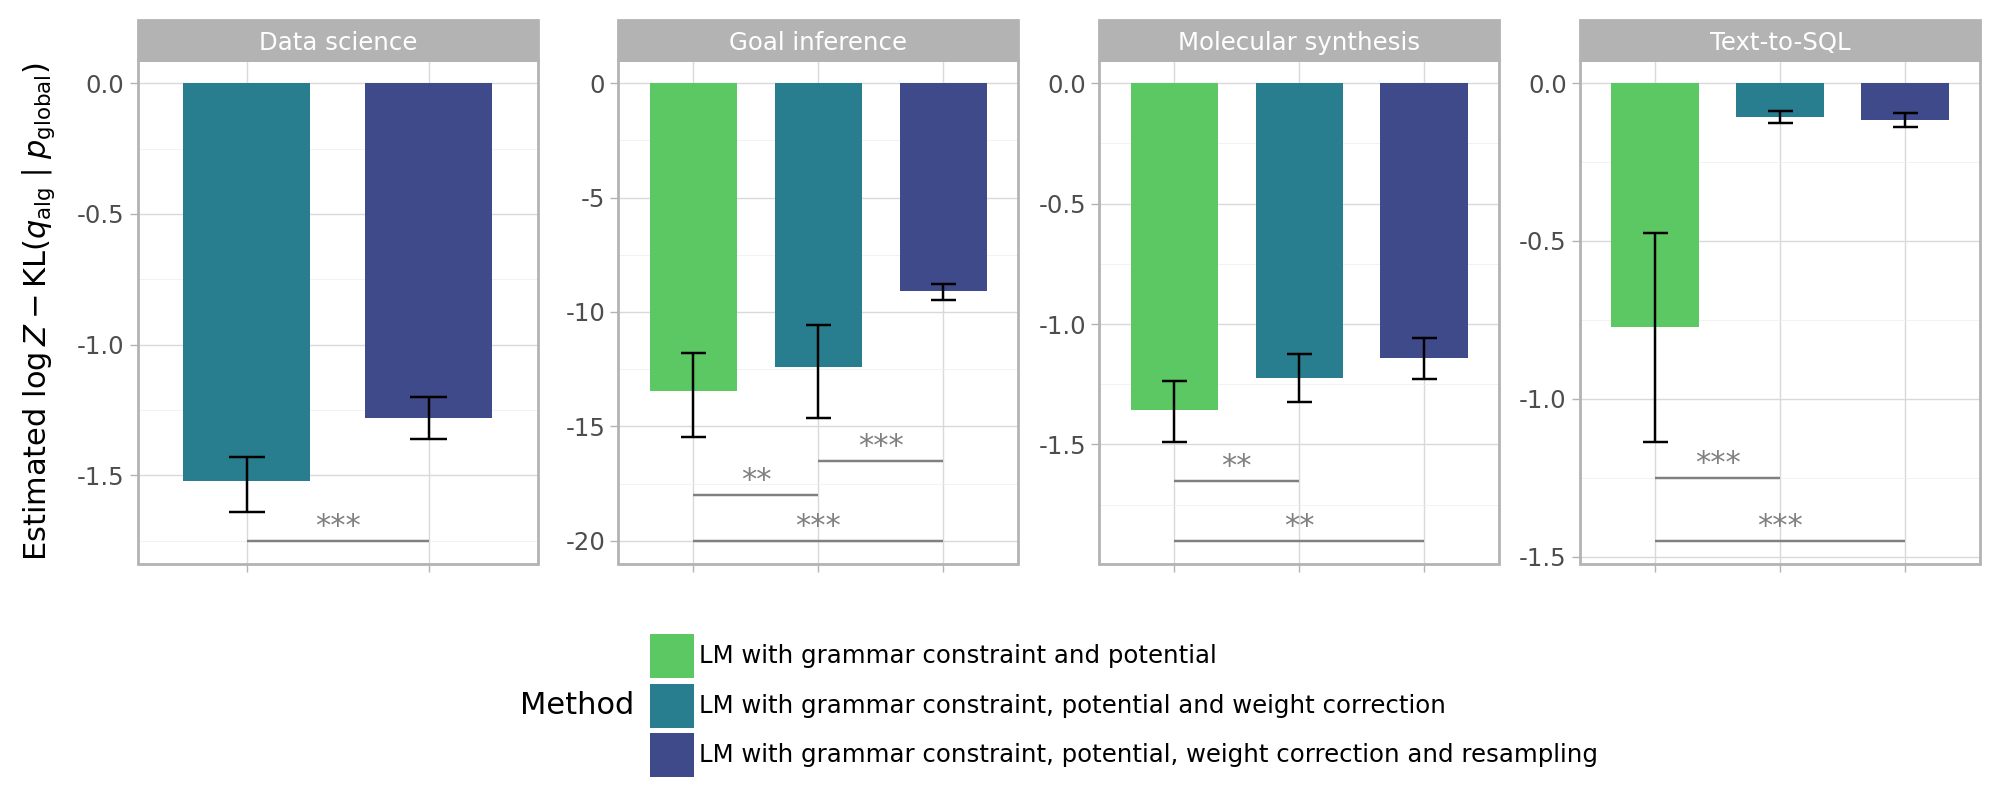

In [124]:
from plotnine import (
        ggplot, aes, geom_bar, geom_errorbar, facet_wrap, theme_light, 
        labs, theme, element_text, guides, guide_legend, scale_fill_manual,
        element_blank, xlab, geom_segment, geom_text, position_dodge, arrs
)
import plotnine as pn
from pandas import CategoricalDtype


method_order = CategoricalDtype(categories=methods, ordered=True)
df['Method'] = df['method'].astype(method_order)

colors = ["#5CC863",  "#287D8E", "#3E4A89", "#440154"] # "#FDE725", 


annotations = pd.DataFrame({
        'domain': [
                'Text-to-SQL', 'Text-to-SQL', 
                'Molecular synthesis', 'Molecular synthesis',
                'Data science',
                'Goal inference', 'Goal inference', 'Goal inference'
        ],
        'x_start': [
                'with_potential', 'with_potential', 
                'with_potential', 'with_potential',
                'with_potential_and_debiasing',
                'with_potential', 'with_potential_and_debiasing', 'with_potential'
        ],
        'x_end': [
                'with_potential_and_debiasing','with_resampling', 
                'with_potential_and_debiasing', 'with_resampling',
                'with_resampling',
                'with_potential_and_debiasing', 'with_resampling', 'with_resampling'
        ],
        'x_mid' : [
                1.5, 2, 1.5, 2, 1.5, 1.5, 2.5, 2
        ],
        'y': [-1.25, -1.45, -1.65, -1.9, -1.75, -18, -16.5, -20],

        'label': ['***', '***', '**', '**', '***', '**', '***', '***'],
        'Method' : ['with_potential'] * 8 # ignored
}
)


plot = (ggplot(df, aes(x='Method', y='mean', fill='Method'))
        + geom_bar(stat='identity', position='dodge', width=0.7)
        + geom_errorbar(aes(ymin='ci_lower', ymax='ci_upper'), width=0.2)
        + pn.facet_wrap('~ domain', scales='free', nrow=1)
        + theme_light()
        + labs(title='', y='Estimated $\log Z - \\text{KL}(q_\\text{alg} \mid p_\\text{global})$', x='')
        + theme(axis_text_x=element_blank(), legend_position='bottom', figure_size=(10, 4),)
        + guides(fill=guide_legend())
        + scale_fill_manual(
                values=colors, 
                labels=[
                        'LM with grammar constraint and potential', 
                        'LM with grammar constraint, potential and weight correction', 
                        'LM with grammar constraint, potential, weight correction and resampling'
                ]
        ) 
        + guides(fill=guide_legend(nrow=3))
        + geom_segment(
                annotations, 
                aes(x='x_start', xend='x_end', y='y', yend='y'), 
                color='grey', 
                size=0.5
        ) +
        geom_text(annotations, 
                aes(x='x_mid', y='y', label='label'), 
                position=position_dodge(width=0.8), 
                va='bottom', ha='center', color='grey')
)

plot.save('kl_plot.png', width=10, height=4, dpi=300)

plot

----